```
# !pip install pydot
# keras 모델 구조를 시각화해주는 도구
```

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
%cd /content/drive/MyDrive/인사교/DL

/content/drive/MyDrive/인사교/DL


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [12]:
from tensorflow.keras.applications import EfficientNetV2S # 최신 이미지 분류 모델 중에 하나

In [13]:
data = np.load('./data/brain_tumor_data.npz')
data
# npz 확장자 : numpy에서 제공된 확장자로, 압축된 형식의 배열로 저장(바이너리 파일)

NpzFile './data/brain_tumor_data.npz' with keys: X_train, X_test, y_train, y_test, DESC

In [14]:
print(data['DESC'])

[brain_tumor_dataset] 24.01.22 created by sjy, data from kaggle
                    name of classes:
                    - [0-'glioma_tumor', 1- 'meningioma_tumor', 2- 'no_tumor',3- 'pituitary_tumor']
                    - glioma tumor 신경교종: 뇌와 척수의 내부에 있는 신경교세포에서 기원하는 종양
                    - meningioma tumor 뇌수막종: 뇌를 둘러싸고 있는 지주막 세포에서 기원하는 종양
                    - no_tumor 종양x
                    - pituitary adenoma 뇌하수체 종양: 뇌 조직 중 호르몬 분비를 담당하는 뇌하수체에 발생하는 모든 양성 종양

                    data info
                    - X_train2: (2870, 224, 224, 3)
                    - y_train2: (2870, 4)
                    - X_test2: (394, 224, 224, 3)
                    - y_test2: (394, 4)
                    


In [15]:
# 각각의 데이터들 변수에 할당
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2870, 224, 224, 3), (394, 224, 224, 3), (2870, 4), (394, 4))

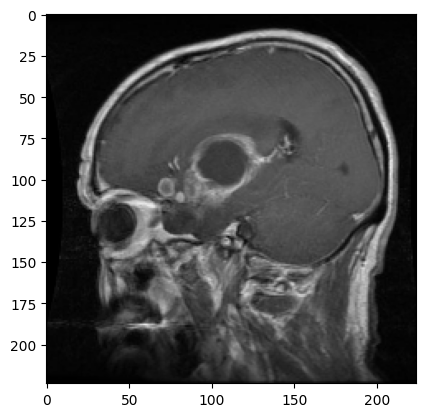

In [9]:
plt.imshow(X_train[50].astype('uint8')) # RGB 데이터인데, 부동소수점으로 표현되어 있어서, int형으로 형변환
plt.show()

In [10]:
y_train[50]

array([1., 0., 0., 0.], dtype=float32)

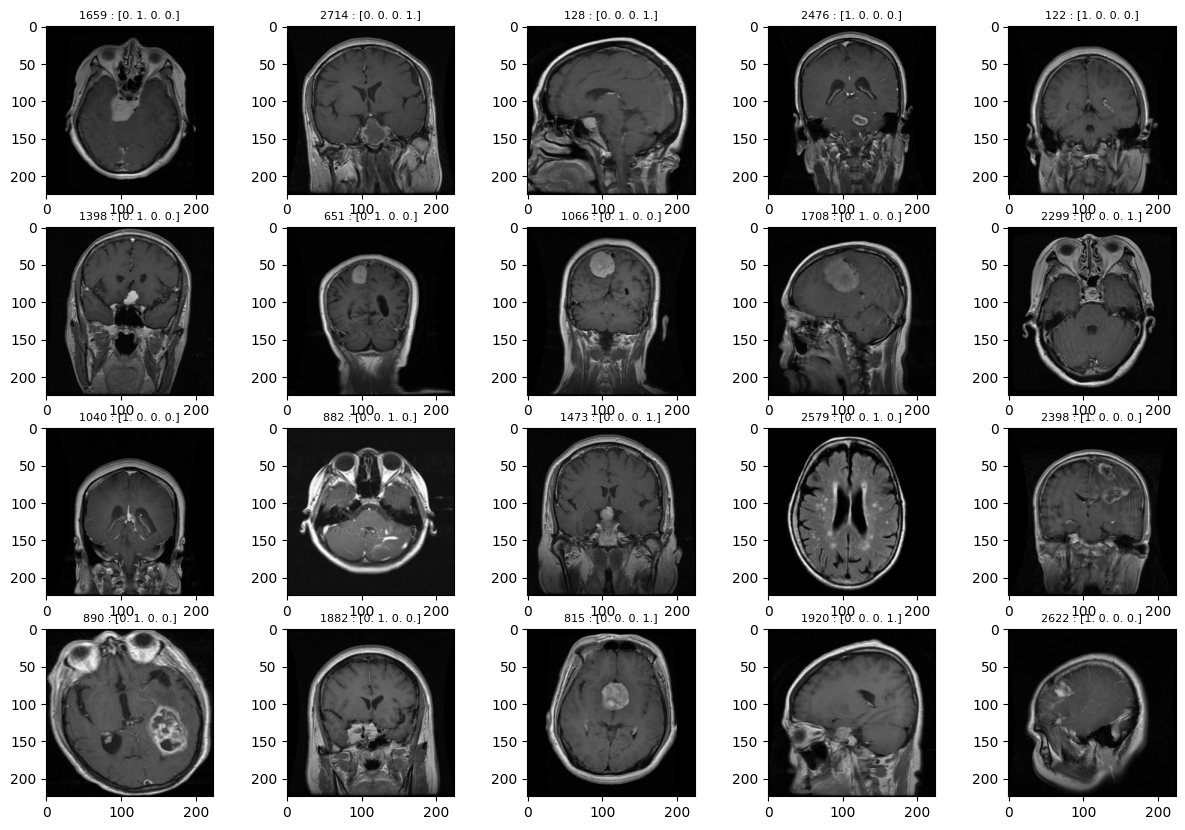

In [11]:
# 랜덤하게 인덱스 선택해서 이미지 출력
rd_list = np.random.randint(0, 2870, size = 20)
plt.figure(figsize = (15, 10))
for i in range(len(rd_list)):
  plt.subplot(4, 5, i + 1)
  plt.title(f'{rd_list[i]} : {y_train[rd_list[i]]}', fontdict = {'fontsize' : 8})
  plt.imshow(X_train[rd_list[i]].astype('int32'))


### 전이학습 수행

In [33]:
image_prepro = EfficientNetV2S(
    include_top = False,
    weights = 'imagenet', # 수천가지 카테고리별로  학습 된 가중치
    input_shape = (224, 224, 3), # 입력 모양
    pooling = 'max', # 최종 출력에서 Global MaxPooling을 적용
)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.655445 to fit



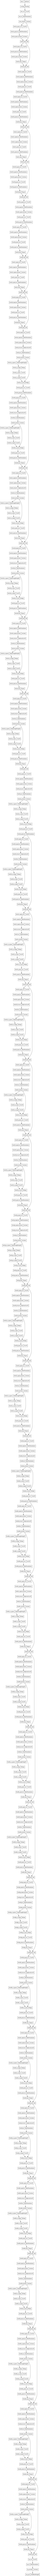

In [12]:
from tensorflow.keras.utils import plot_model # 시각화 도구(pydot 필요)
plot_model(image_prepro)

In [14]:
# 뼈대
tumor_model = Sequential()

# 특성추출부
tumor_model.add(image_prepro)

# 은닉층
tumor_model.add(Flatten())
tumor_model.add(Dense(2048, 'relu'))
tumor_model.add(Dense(1024, 'relu'))
tumor_model.add(Dense(512, 'relu'))
tumor_model.add(Dropout(0.2))
tumor_model.add(Dense(256, 'relu'))

# 출력층
tumor_model.add(Dense(4, 'softmax'))

In [15]:
# 학습방법 설정
tumor_model.compile(
    loss = 'categorical_crossentropy', # 다중 분류 시, y데이터가 원핫 벡터인 경우 적용!
    # sparse_categorical_crossentropy : y 데이터가 1차원인 경우 적용!
    metrics = ['accuracy'],
    optimizer = 'Adam'
)

In [23]:
# 조기학습 중단
early = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 8, # 인내하는 정도
    verbose = 1
)

In [ ]:
# 학습
h = tumor_model.fit(
    X_train, y_train,
    validation_split = 0.2,
    epochs = 100,
    callbacks = [early],
    batch_size = 32
)

Epoch 1/100


KeyboardInterrupt: 

In [ ]:
tumor_model.evaluate(X_test, y_test)

- 딥러닝 성능을 끌어올려보자!
- 팀별로 성능 확인!!

In [21]:
image_prepro.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 24)         648       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 24)         96        ['stem_conv[0][0]']           
 n)                                                                                

In [34]:
image_prepro.trainable = True

In [35]:
for layer in image_prepro.layers:
    if layer.name == 'top_conv':
        layer.trainable = True
    else:
        layer.trainable = False

In [36]:
model = Sequential()

model.add(image_prepro)
# 은닉층
model.add(Flatten())
model.add(Dense(2048, 'relu'))
model.add(Dense(1024, 'relu'))
model.add(Dense(512, 'relu'))
model.add(Dropout(0.2))
model.add(Dense(256, 'relu'))

# 출력층
model.add(Dense(4, 'softmax'))

In [24]:
image_prepro.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 24)         648       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 24)         96        ['stem_conv[0][0]']           
 n)                                                                                

In [37]:
import tensorflow.keras.optimizers as Adam

model.compile(
    optimizer = 'Adam',
    loss = 'categorical_crossentropy', # 다중 분류 시, y데이터가 원핫 벡터인 경우 적용!
    # sparse_categorical_crossentropy : y 데이터가 1차원인 경우 적용!
    metrics = ['accuracy'],
)

In [38]:
# 학습
h = model.fit(
    X_train, y_train,
    validation_split = 0.2,
    epochs = 100,
    callbacks = [early],
    batch_size = 32
)

Epoch 1/100
72/72 [==============================] - 34s 236ms/step - loss: 1.3059 - accuracy: 0.5997 - val_loss: 0.5517 - val_accuracy: 0.7822
Epoch 2/100
72/72 [==============================] - 12s 168ms/step - loss: 0.4596 - accuracy: 0.8306 - val_loss: 0.4083 - val_accuracy: 0.8449
Epoch 3/100
72/72 [==============================] - 12s 169ms/step - loss: 0.3414 - accuracy: 0.8667 - val_loss: 0.3741 - val_accuracy: 0.8589
Epoch 4/100
72/72 [==============================] - 12s 168ms/step - loss: 0.2632 - accuracy: 0.9064 - val_loss: 0.5040 - val_accuracy: 0.8223
Epoch 5/100
72/72 [==============================] - 12s 167ms/step - loss: 0.1893 - accuracy: 0.9260 - val_loss: 0.3273 - val_accuracy: 0.9007
Epoch 6/100
72/72 [==============================] - 12s 166ms/step - loss: 0.1769 - accuracy: 0.9377 - val_loss: 0.5114 - val_accuracy: 0.8171
Epoch 7/100
72/72 [==============================] - 12s 172ms/step - loss: 0.1504 - accuracy: 0.9482 - val_loss: 0.4873 - val_accuracy:

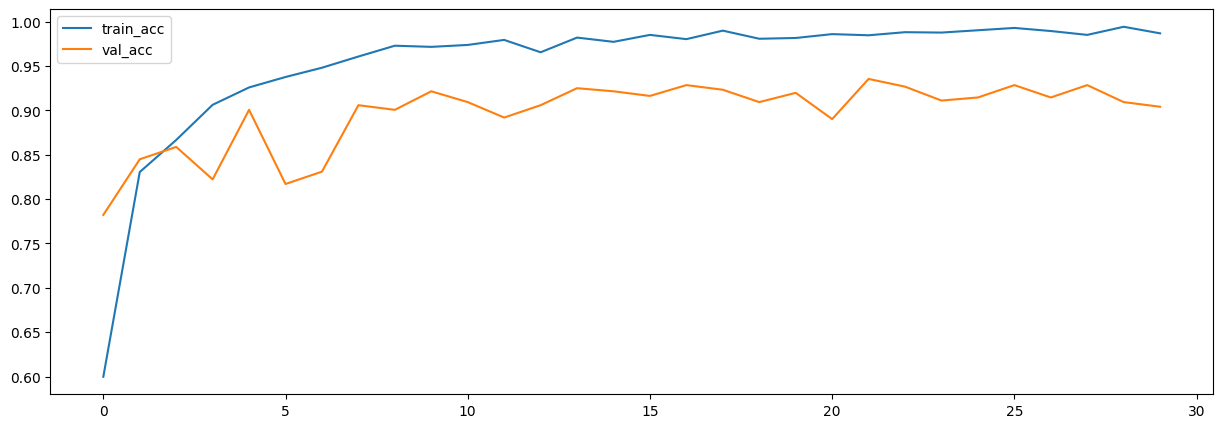

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 5))
plt.plot(h.history['accuracy'], label = 'train_acc')
plt.plot(h.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.show()

In [27]:
from tensorflow.keras.applications import EfficientNetV2S # 최신 이미지 분류 모델 중에 하나
image_prepro = EfficientNetV2S(
    include_top = False,
    weights = 'imagenet', # 수천가지 카테고리별로  학습 된 가중치
    input_shape = (224, 224, 3), # 입력 모양
    pooling = 'max', # 최종 출력에서 Global MaxPooling을 적용
)

In [28]:
image_prepro.trainable = True

In [29]:
for layer in image_prepro.layers:
    if layer.name == 'top_conv':
        layer.trainable = True
    else:
        layer.trainable = False

In [32]:
model = Sequential()

model.add(image_prepro)

# 은닉층
model.add(Flatten())
model.add(Dense(2048, 'relu'))
model.add(Dropout(0.3))  # 새로운 드롭아웃 추가
model.add(Dense(1024, 'relu'))
model.add(Dense(512, 'relu'))
model.add(Dropout(0.3))  # 기존 드롭아웃
model.add(Dense(256, 'relu'))

# 출력층
model.add(Dense(4, 'softmax'))


In [33]:
import tensorflow.keras.optimizers as Adam

model.compile(
    optimizer = 'Adam',
    loss = 'categorical_crossentropy', # 다중 분류 시, y데이터가 원핫 벡터인 경우 적용!
    # sparse_categorical_crossentropy : y 데이터가 1차원인 경우 적용!
    metrics = ['accuracy'],
)

In [34]:
# 학습
h2 = model.fit(
    X_train, y_train,
    validation_split = 0.2,
    epochs = 100,
    callbacks = [early],
    batch_size = 32
)

Epoch 1/100
72/72 [==============================] - 34s 220ms/step - loss: 1.6002 - accuracy: 0.5235 - val_loss: 0.8286 - val_accuracy: 0.6794
Epoch 2/100
72/72 [==============================] - 12s 165ms/step - loss: 0.5528 - accuracy: 0.7857 - val_loss: 0.4582 - val_accuracy: 0.8206
Epoch 3/100
72/72 [==============================] - 12s 173ms/step - loss: 0.3623 - accuracy: 0.8741 - val_loss: 0.4087 - val_accuracy: 0.8484
Epoch 4/100
72/72 [==============================] - 12s 174ms/step - loss: 0.3211 - accuracy: 0.8794 - val_loss: 0.3747 - val_accuracy: 0.8676
Epoch 5/100
72/72 [==============================] - 12s 172ms/step - loss: 0.2321 - accuracy: 0.9190 - val_loss: 0.3665 - val_accuracy: 0.8711
Epoch 6/100
72/72 [==============================] - 12s 171ms/step - loss: 0.2207 - accuracy: 0.9238 - val_loss: 0.2663 - val_accuracy: 0.9164
Epoch 7/100
72/72 [==============================] - 12s 171ms/step - loss: 0.1487 - accuracy: 0.9421 - val_loss: 0.2784 - val_accuracy:

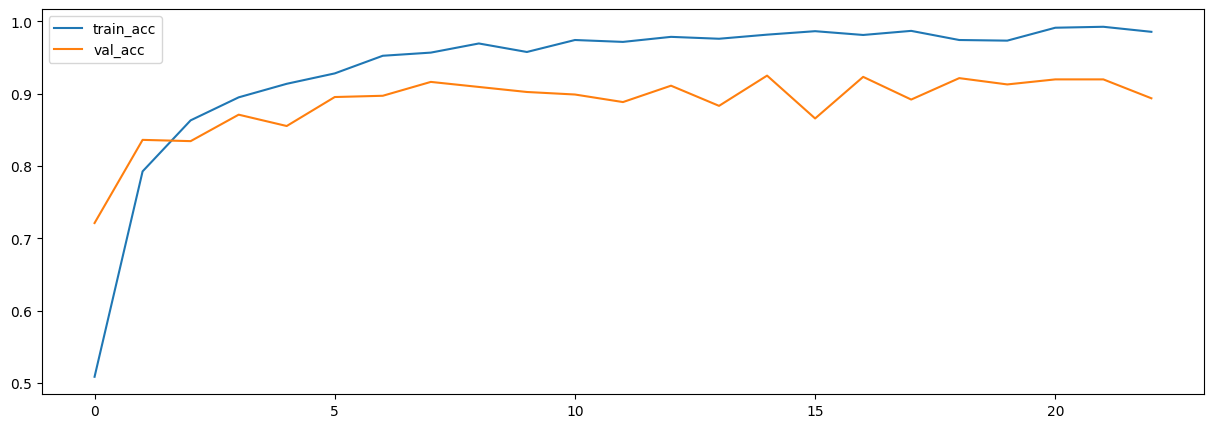

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 5))
plt.plot(h1.history['accuracy'], label = 'train_acc')
plt.plot(h1.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.show()

In [20]:
model = Sequential()

model.add(image_prepro)

# 은닉층
model.add(Flatten())
model.add(Dense(2048, 'relu'))
model.add(Dropout(0.3))  # 드롭아웃 추가
model.add(Dense(1024, 'relu'))
model.add(Dropout(0.3))  # 드롭아웃 추가
model.add(Dense(512, 'relu'))
model.add(Dropout(0.3))  # 기존 드롭아웃
model.add(Dense(256, 'relu'))

# 출력층
model.add(Dense(4, 'softmax'))


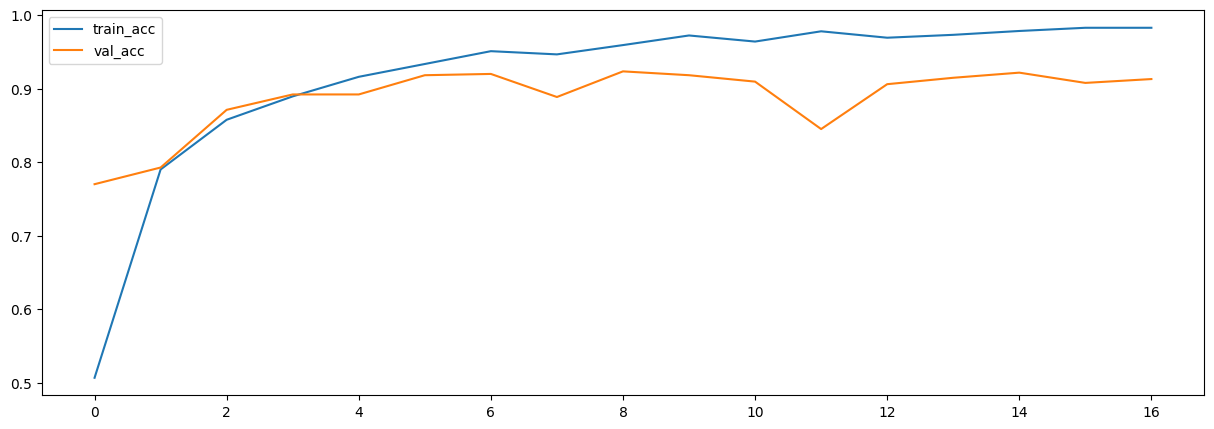

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 5))
plt.plot(h2.history['accuracy'], label = 'train_acc')
plt.plot(h2.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.show()

In [26]:
model.evaluate(X_test, y_test)

13/13 [==============================] - 3s 219ms/step - loss: 1.6974 - accuracy: 0.7614


[1.6973934173583984, 0.7614213228225708]

In [35]:
model.evaluate(X_test, y_test)

13/13 [==============================] - 2s 125ms/step - loss: 1.0075 - accuracy: 0.8173


[1.0075311660766602, 0.817258894443512]